In [ ]:
!nvidia-smi

Sun Aug 15 16:32:57 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from tqdm.notebook import tqdm
import torch

In [ ]:
!pip install -q -U segmentation-models-pytorch
import segmentation_models_pytorch as smp

In [ ]:
!unzip '/content/drive/MyDrive/kaggle/deepglobe/deepglobe-road-extraction-dataset.zip' -d '/content/deepglobe'

# Reading data

In [ ]:
# # reading data
path = '/content/deepglobe/'
metaData = pd.read_csv(path+'metadata.csv')
metaData = metaData[metaData['split']=='train']

In [ ]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from PIL import Image
from torchvision import transforms
import torchvision.transforms.functional as TF

class MyDataset(Dataset):
    def __init__(self, df, transform=None, augmentation=False, idx = None):
        self.df = df
        self.transform = transform
        self.path = '/content/deepglobe/'
        self.augmentation  = augmentation
    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        #SIZE = 512
        img = cv2.imread(self.path+self.df['sat_image_path'][index])
        #img = cv2.resize(img,(SIZE,SIZE))
        
        mask = cv2.imread(self.path+self.df['mask_path'][index],0)
        #mask = cv2.resize(mask,(SIZE,SIZE))
        ret, mask = cv2.threshold(mask,127,255,cv2.THRESH_BINARY)

        img = Image.fromarray(img)
        mask = Image.fromarray(mask)

        if self.transform is not None:
            img = self.transform(img)

        # Data Augmentation
        if self.augmentation :
          prob = np.random.choice([True, False], size=(4))
          if prob[0] :
              img = TF.hflip(img)
              mask = TF.hflip(mask)
          if prob[1] :
              img = TF.vflip(img)
              mask = TF.vflip(mask)
          if prob[2] :
              if prob[3] :
                  img = TF.rotate(img, 90)
                  mask = TF.rotate(mask, 90)
              else:
                  img = TF.rotate(img, -90)
                  mask = TF.rotate(mask, -90)

        SIZE = img.shape[-1]
        return img.view(-1,SIZE,SIZE), np.array(mask).reshape(-1,SIZE,SIZE)//255

img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.], [1.])
])

trainData = MyDataset(metaData[:int(len(metaData)*0.9)], transform=img_transform,augmentation=True)
valData = MyDataset(metaData[int(len(metaData)*0.9):].reset_index(), transform=img_transform)

trainLoader = DataLoader(trainData, batch_size=4, shuffle=True)
valLoader = DataLoader(valData, batch_size=4, shuffle=True)

In [ ]:
it = iter(trainLoader)
x, y = next(it)
print(x.shape)
print(y.shape)

torch.Size([8, 3, 1024, 1024])
torch.Size([8, 1, 1024, 1024])


# Train Deeplab3+

In [ ]:
model = smp.DeepLabV3Plus(encoder_name='resnet50',encoder_weights='imagenet',
                          classes=1, activation='sigmoid')

In [ ]:
model = torch.load('drive/MyDrive/pretrained/DeepLabv3p(4,12).pt')

In [ ]:
# Set device: `cuda` or `cpu`
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# define loss function
loss = smp.utils.losses.DiceLoss()

# define metrics
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

# define optimizer
optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.00008),
])

# define learning rate scheduler (not used in this NB)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=1, T_mult=2, eta_min=5e-5,
)

In [ ]:
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [ ]:
for i in range(13,15):
    # Perform training & validation
    print('\nEpoch: {}'.format(i+1))
    train_logs = train_epoch.run(trainLoader)
    valid_logs = valid_epoch.run(valLoader)

    torch.save(model,'drive/MyDrive/pretrained/DeepLabv3p(4,%d).pt'%i)




Epoch: 14
train:   0%|          | 0/1401 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


valid: 100%|██████████| 156/156 [01:35<00:00,  1.63it/s, dice_loss - 0.2359, iou_score - 0.6244]

Epoch: 15
valid: 100%|██████████| 156/156 [01:34<00:00,  1.65it/s, dice_loss - 0.2363, iou_score - 0.6233]


# Test

In [ ]:
model = torch.load('drive/MyDrive/pretrained/DeepLabv3p(4,9).pt')

In [ ]:
it = iter(valLoader)
x, y = next(it)
y = y.type(torch.int8)
print(x.shape,y.shape)

torch.Size([4, 3, 1024, 1024]) torch.Size([4, 1, 1024, 1024])


In [ ]:
x2 = x.cuda()
pred = model(x2)
pred2 = pred.detach().squeeze().cpu().numpy()

torchmetrics : tensor(0.7202)


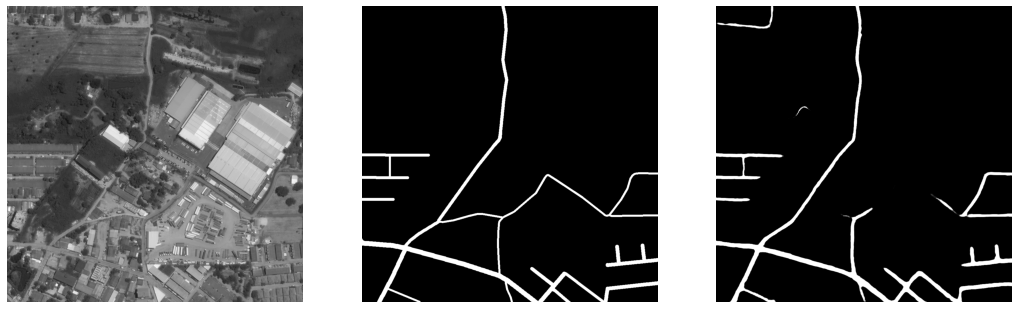

In [ ]:
fig = plt.figure(figsize=(18,3*18))
i = 3
fig.add_subplot(1,3,1)
gray = np.mean(x[i].numpy(),axis=0)
plt.imshow(gray,cmap='gray')
plt.axis('off')

fig.add_subplot(1,3,2)
plt.imshow(y[i,0].cpu(),cmap='gray')
plt.axis('off')

fig.add_subplot(1,3,3)
plt.imshow(pred2[i],cmap='gray')
plt.axis('off')
#plt.show()

pred = pred.cpu()
y = y.cpu()
iou1 = metrics[0](pred[i,0], y[i,0])
print('torchmetrics :',iou1)
#computeIoU(y[i,0].numpy(),pred[i,0].cpu().detach().numpy())
#print(jaccard_similarity_score(y[i,0].numpy(),pred[i,0].cpu().detach().numpy(),normalize=True))

In [ ]:
valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [ ]:
valid_logs = valid_epoch.run(valLoader)

valid: 100%|██████████| 78/78 [01:16<00:00,  1.02it/s, dice_loss - 0.02061, iou_score - 0.9746]


# Bluh Bluh

In [ ]:
def run_histogram_equalization(rgb_img):

    # convert from RGB color-space to YCrCb
    ycrcb_img = cv2.cvtColor(rgb_img, cv2.COLOR_BGR2YCrCb)

    # equalize the histogram of the Y channel
    ycrcb_img[:, :, 0] = cv2.equalizeHist(ycrcb_img[:, :, 0])

    # convert back to RGB color-space from YCrCb
    equalized_img = cv2.cvtColor(ycrcb_img, cv2.COLOR_YCrCb2RGB)
    return equalized_img

(1024, 1024, 3)


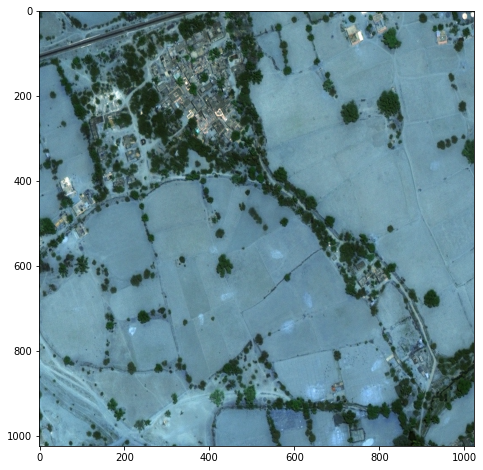

In [ ]:
img = x[0]
img2 = img.permute(2,1,0)
img2 = img2.numpy()
img2 = np.uint8(img2*255)
#grayimg = cv2.cvtColor(img2, cv2.COLOR_BGR2HSV)
print(img2.shape)

plt.figure(figsize=(8,8))
plt.imshow(img2)
plt.show()

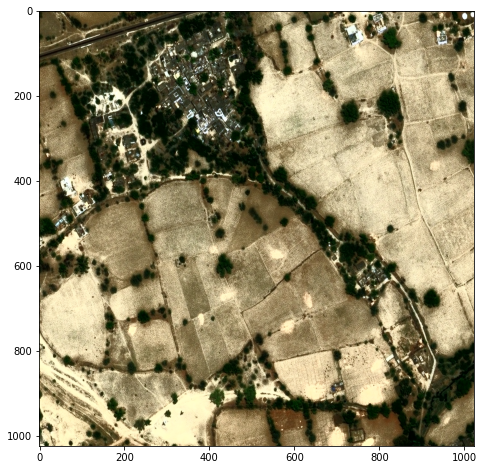

In [ ]:
eqimg = run_histogram_equalization(img2)

plt.figure(figsize=(8,8))
plt.imshow(eqimg)
plt.show()

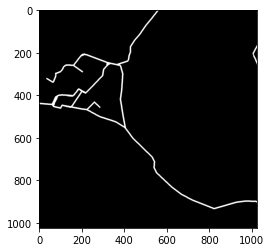

In [ ]:
plt.imshow(y[0,0],cmap='gray')
plt.show()